# Exercise 06: Robustness and Scale-Free Networks

**Assignment due:** *April 2 2019*  

In many networked systems, the *robustness* against failures or sabotage is a major concern. In this exercise, we explore how the distribution of degrees influences the robustness of complex networks. Apart from sparse Erdös-Rènyi random networks with a Poissonian degree distribution, we also study networks whose degree distributions follow a Zipf distribution. This class of complex networks offers a number of interesting characteristics, that we will discuss in the next lecture.

In [1]:
#BOILERPLATE_CODE
%matplotlib inline

import matplotlib.pyplot as plt
from collections import Counter

plt.style.use('ggplot')

import numpy as np
import pathpy as pp

### Task 1: Emergence of a giant connected component

Study the size of the largest connected component in random graphs generated by the $G(n,p)$ model. Plot the largest connected component size as a function of p for 20 uniformly spaced samples in the range of $[0, 0.05]$. Repeat your experiment for a number of nodes of $n = 100$ and $n = 200$.
To generate the $G(n,p)$ model, use the function from the previous exercises.

In [2]:
def Gnp(n, p): # manually code this function
    return pp.algorithms.random_graphs.erdoes_renyi_gnp(n=n, p=p, directed=False, self_loops = False)

def rel_lcc_ncount(n, p):
    g = Gnp(n=n, p=p) 
    pp.algorithms.components.reduce_to_gcc(g)
    return g.ncount()/n
    
                                                        
def plot_rel_lcc(n_values, p_values):
    n_values, p_values = np.asarray(n_values), np.asarray(p_values)
                                                        
    fig = plt.figure()
    ax = plt.subplot(111)

    for n in n_values:
        lcc_ncount =[rel_lcc_ncount(n, p) for p in p_values]

        ax.vlines(1./n,ymin=0, ymax=1.01, linestyles='--', colors='Grey')
        ax.plot(p_values, lcc_ncount, label=r'{}'.format(n))
        ax.set_xlabel(r'Probability $p$')
        ax.set_ylabel(r'Relative LCC')
        ax.set_xlim(min(p_values),max(p_values))
        ax.set_ylim(0, 1.01)
        ax.legend(title=r'Nodes $n$', loc='lower right')
    
    fig.tight_layout(pad=.1)
    fig.savefig('./task_01_lcc.pdf')                                                

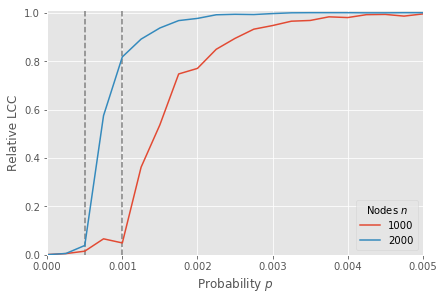

In [3]:
p_values = np.linspace(.0, .005, 21)
n_values = np.array([1000, 2000])

plot_rel_lcc(n_values, p_values)

### Task 2: Molloy-Reed Criterion

Read the collaboration network of the `gentoo` project from the SQLite database.

In [4]:
#BOILERPLATE_CODE

# import matplotlib.mlab as mlab
import sqlite3

con = sqlite3.connect('./01_networks.db')
con.row_factory = sqlite3.Row

n_gentoo = pp.Network.from_sqlite(con.execute('SELECT source, target FROM gentoo'), directed=False)

print("\n" + n_gentoo.summary())

2021-12-24 16:26:39 [Severity.INFO]	Retrieving links from database ...

Undirected network
Nodes:				403
Links:				513



Implement a function that plots the probability generating function of a degree distribution, based on the definition given in L05, slide 12. Plot the generating function of the `gentoo` network.

In [5]:
def degrees(network):
    Nk = Counter(network.degrees())
    for iKey, iVal in Nk.items():
        Nk[iKey] /= network.ncount()
    return Nk    

def gen_func(network, x_range):
    g_0 = np.zeros_like(x_range, dtype=float)
    
    Nk = degrees(network)
    
    for xInd, xVal in enumerate(x_range[1:], 1):
        for iKey, iVal in Nk.items():
            g_0[xInd] += iVal * xVal ** iKey

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(x_range, g_0)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$G_{0}\left(x\right)$') 
    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)

    fig.savefig('./graphics/exercise_06_task_2_generating_func.pdf')
            
    return g_0

/tmp/ipykernel_26984/3343933018.py:14: RuntimeWarning: underflow encountered in double_scalars
  g_0[xInd] += iVal * xVal ** iKey


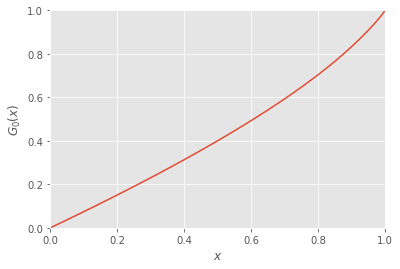

In [6]:
x_range = np.linspace(0, 1, 101)
g_0 = gen_func(network=n_gentoo, x_range=x_range)   

Implement a function that calculates the Molloy Reed criterion for a given degree sequence. Test your function with the `gentoo` network. Would you expect a giant connected component?

In [7]:
def test_molloy_reed_crit(network):
    Nk = degrees(network=network)
    var_ = 0.
    mu_ = 0.
    for iKey, iVal in Nk.items():
        var_ += iKey**2 * iVal
        mu_ += iKey * iVal

    return var_ / mu_ > 2        

In [8]:
test_molloy_reed_crit(n_gentoo)

True

Compare the diameter and average shortest path length of the largest connected component in the empirical network with those of random microstates generated using the $G(n,m)$ and the Molloy-Reed model. For the Molloy-Reed model, you can reuse the function from last week's exercise. What do you observe?

In [9]:
# code from previous week's exercise sheet

def is_graphic_Erdos_Gallai(seq):
    seq = np.asarray(seq)
    if np.sum(seq)%2 != 0:
#         Sum of degrees is odd.
        return False
    
    for i in range(1, len(seq)):
        lht = np.sum(seq[:i+1])
        rht = i * (i - 1)
        for j in range(i+1, len(seq)):
            rht += min(j, seq[j])
        if lht > rht:
#           Unequality of Erdős–Gallai theorem not fulfilled')
            return False
    
    return True


def MolloyReed(degrees): 
    n = len(degrees)
    g = pp.Network(directed=False)
    for i in range(n):
        g.add_node(i)
        
    if is_graphic_Erdos_Gallai(degrees):        
        stubs = [i for i, iVal in enumerate(degrees) for k in range(iVal)]
        while stubs:
            i = np.random.choice(stubs)
            stubs.remove(i)
            j = np.random.choice(stubs)
            stubs.remove(j)
            g.add_edge(i, j)
            
        return g
    
    else:
        return None
    
def degree_sequence(network):
    return [k for k, count in Counter(network.degrees()).items() for j in range(count)]    

In [10]:
def compare_empirical_vs_random_network(network, sample_size=50):
    pp.algorithms.components.reduce_to_gcc(network)
    diameter_network = pp.algorithms.shortest_paths.diameter(network)
    avg_path_len_network = pp.algorithms.shortest_paths.avg_path_length(network)

    degrees = degree_sequence(network=network)

    mean_diameter_mrm = 0.
    mean_avg_path_len_mrm = 0.
    mean_diameter_gnm = 0.
    mean_avg_path_len_gnm = 0.
    mean_lcc_mrm = 0.
    mean_lcc_gnm = 0.

    for s in range(sample_size):
        n_mrm = MolloyReed(degrees=degrees)
        n_gnm = pp.algorithms.random_graphs.erdoes_renyi_gnm(n=network.ncount(), m=network.ecount())

        pp.algorithms.components.reduce_to_gcc(n_mrm)
        pp.algorithms.components.reduce_to_gcc(n_gnm)

        mean_diameter_mrm +=  pp.algorithms.shortest_paths.diameter(n_mrm)
        mean_avg_path_len_mrm += pp.algorithms.shortest_paths.avg_path_length(n_mrm)
        mean_diameter_gnm += pp.algorithms.shortest_paths.diameter(n_gnm)
        mean_avg_path_len_gnm += pp.algorithms.shortest_paths.avg_path_length(n_gnm)
        mean_lcc_mrm += n_mrm.ncount()
        mean_lcc_gnm += n_gnm.ncount()

    mean_diameter_mrm /= sample_size
    mean_avg_path_len_mrm /= sample_size
    mean_diameter_gnm /= sample_size
    mean_avg_path_len_gnm /= sample_size
    mean_lcc_mrm /= sample_size * network.ncount()
    mean_lcc_gnm /= sample_size * network.ncount()

    print(
        '\t \t gento \t M-R m \t Gnm \n Diameter \t {:.2f} \t {:.2f} \t {:.2f} \n Avg path len\t {:.2f} \t {:.2f} \t {:.2f} \n Rel. LCC \t {:.2f} \t {:.2f} \t {:.2f}'
         .format(diameter_network, mean_diameter_mrm, mean_diameter_gnm,
                 avg_path_len_network, mean_avg_path_len_mrm, mean_avg_path_len_gnm,
                 1, mean_lcc_mrm, mean_lcc_gnm
                )
         )

In [11]:
compare_empirical_vs_random_network(n_gentoo, sample_size=50)

	 	 gento 	 M-R m 	 Gnm 
 Diameter 	 8.00 	 8.48 	 14.68 
 Avg path len	 3.10 	 3.34 	 6.15 
 Rel. LCC 	 1.00 	 0.75 	 0.90


## Task 3: Robustness of random networks

Write a function that removes a fraction $q$ of **random nodes** from a given network. In other words, nodes have a uniform probability $q$ to be removed from the network. Whenever a node is removed, all adjacent links are removed as well.

In [12]:
#BOILERPLATE_CODE
def remove_random_frac(network, q):
    start = len(network.nodes)
    while (network.ncount()/start>1-q):
        node = np.random.choice(list(network.nodes))
        network.remove_node(node)
    return network

Write a function that removes a fraction $q$ of the **highest degree nodes** from a given network. In other words, we consider an *attack* or *sabotage* scenario in which the nodes with the highest degrees are removed. Again, whenever a node is removed, all adjacent links should be removed as well.

In [13]:
#BOILERPLATE_CODE
def remove_top_frac(network, frac):
    start = len(network.nodes)
    while (network.ncount()/start>1-frac):
        node = sorted(network.nodes.items(), key= lambda k:k[1]['degree'], reverse=True)[0][0]
        network.remove_node(node)
    return network

Test your functions using random networks generated from the $G(n,p)$ model for parameters $n=200$ and $np=3$. For the generation of these networks, you can use your implementation from previous exercises.

In [14]:
n: int = 200
np_: float = 3.
remove_random_frac(Gnp(n=n, p=np_/n), .2)

In [15]:
remove_top_frac(Gnp(n=n, p=np_/n), .2)

For $30$ random failure rates $q$ chosen uniformly from the range $[0,0.95]$ plot the relative size of the remaining giant connected component under the random failure model. What fraction of randomly failing nodes can Erdös-Rènyi networks tolerate before the giant connected component disappears? What fraction of most-connected nodes can be removed?

We provide a helper function that simulates random failures or attacks and plots the effect on the largest connected component.

In [20]:
#BOILERPLATE_CODE
def plot_ER_failures_sgcc(q_range, n, p, samples=50, mode="random"):
    sgcc = []

    for q in q_range:
        s = 0.
        for i in range(samples):
            g = Gnp(n=n, p=p)
            if mode == "random":
                g = remove_random_frac(g, q)
            else:
                g = remove_top_frac(g, q)
            
            pp.algorithms.components.reduce_to_gcc(g)
            s += g.ncount()
        sgcc.append(s/(samples * n))
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(q_range,sgcc)
    ax.set_xlabel(r'Fraction $q$')
    ax.set_ylabel(r'Size of surviving lcc')
    ax.set_ylim((0,1))
    ax.set_xlim((min(q_range),max(q_range)))
    
    fig.tight_layout(pad=.1)
    fig.savefig('./graphics/exercise_06_task_3_GNP_robustness_{}.pdf'.format(mode))

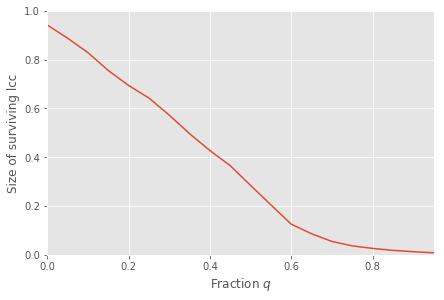

In [21]:
n: int = 200
np_: float = 3.
q_range = np.linspace(.0, .95, 20)

plot_ER_failures_sgcc(q_range=q_range, n=n, p=np_/n)

Repeat your experiment for random networks $n=400$ and $np=5$. How does the shape of the curve change?

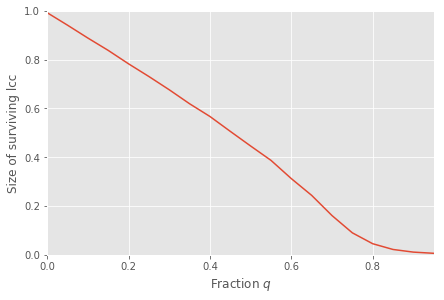

In [18]:
n = 400
np_ = 5.

plot_ER_failures_sgcc(q_range=q_range, n=n, p=np_/n)

For a random network with $n=400$ and $np=3$ and $30$ failure rates $q$ chosen uniformly from the range $[0,0.95]$, plot the relative size of the remaining giant connected component for the attack scenario, i.e. we remove a fraction $q$ of highest degree nodes. How does the shape of the curve change?

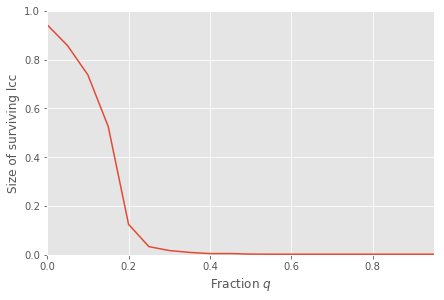

In [19]:
n = 400
np_ = 3.

plot_ER_failures_sgcc(q_range=q_range, n=n, p=np_/n, mode='top')

## Task 4: Scale-free networks

Use the Molloy-Reed model to generate random networks with a **Zipf** degree distribution and exponents $\gamma \in (2, 3.5)$. Use the two functions developed in Task 3 to test the robustness of the generated networks against random failures and attacks for $\gamma=2.1$, $\gamma=2.5$ and $\gamma=2.3$. What do you observe?

Again, we provide a helper function that simplies the study of the effect of node failures in scale-free networks.

In [23]:
#BOILERPLATE_CODE
def plot_SF_failures_sgcc(q_range, n, gamma_values, samples=5, mode='random'):
    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    for gamma in gamma_values:
        sgcc = []
        for q in q_range:
            s = 0.
            for i in range(samples):
                g = None
                while not g:
                    degrees = np.random.zipf(gamma, size=n)
                    g = MolloyReed(degrees=degrees)
                if mode == 'random':
                    g = remove_random_frac(g, q)
                else:
                    g = remove_top_frac(g, q)

                pp.algorithms.components.reduce_to_gcc(g)
                s += g.ncount()
            sgcc.append(s/(samples * n))
            
        ax.plot(q_range, sgcc, label=r'${}$'.format(gamma))
    
    ax.legend(loc='best')
    ax.set_xlabel(r'Fraction $q$')
    ax.set_ylabel(r'Size of surviving lcc')
    ax.set_xlim((min(q_range),max(q_range)))
    ax.set_ylim(0,1)
    
    fig.tight_layout()
    fig.savefig('./graphics/exercise_06_task_4_SF_robustness_{}.pdf'.format(mode))

Now use this function to simulate the effect of random failures and attacks on networks with $n=500$ nodes and $20$ uniformly spaced failure rates $q$ in the range $[0, 0.95]$. What do you observe compared to the case of random Erdös-Rènyi networks?

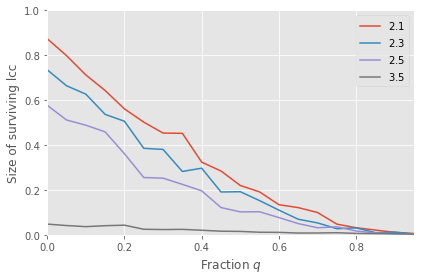

In [24]:
gamma_values = np.array([2.1, 2.3, 2.5, 3.5])
q_range = np.linspace(.0, .95, 20)
n = 500
samples = 20

plot_SF_failures_sgcc(q_range=q_range, n=n, gamma_values=gamma_values, samples=samples)

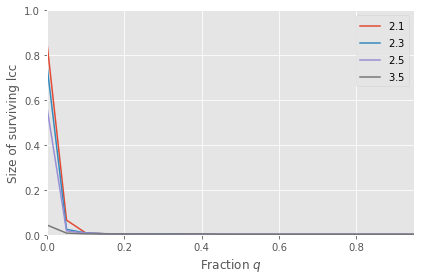

In [25]:
plot_SF_failures_sgcc(q_range=q_range, n=n, gamma_values=gamma_values, samples=samples, mode="top")

For random networks with a **Zipf** degree distribution with $\gamma=2.5$ and $20$ logarithmically spaced network sizes $n \in [100, 1000]$, plot the diameter of the network's largest connected component against the number of nodes. How does the diameter scale with the network size? Compare the scaling of the diameter to that expected for Erdös-Rènyi networks of the same size.

In [26]:
def plot_SF_diameter(gamma, n_values, samples=5):
    diam = []
    diam_gnp = []
    for n in n_values:
        s = 0.
        s_gnp = 0.
        for i in range(samples):
            g = None
            while not g:
                degrees = np.random.zipf(gamma, size=n)
                g = MolloyReed(degrees=degrees)
            
            gnp = Gnp(n=n, p=np.mean(degrees)/n)
            
            pp.algorithms.components.reduce_to_gcc(g)
            pp.algorithms.components.reduce_to_gcc(gnp)
            
            s += pp.algorithms.shortest_paths.diameter(g)
            s_gnp += pp.algorithms.shortest_paths.diameter(gnp)
            
        diam.append(s/samples)
        diam_gnp.append(s_gnp/samples)

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(n_values, diam, label='Zipf')
    ax.plot(n_values, diam_gnp, label='Gnp')
    
    ax.legend(loc='best')
    ax.set_xlabel(r'Number of nodes $n$')
    ax.set_ylabel(r'Diameter $d$')
    ax.set_xlim((min(n_values),max(n_values)))
    ax.set_xscale('log')
    ax.set_yscale('log')

    fig.tight_layout(pad=.1)
    fig.savefig('./graphics/exercise_06_task_4_SF_GNP_diameter.pdf')

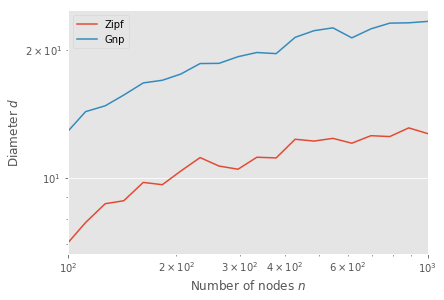

In [32]:
gamma = 2.5
n_values = np.logspace(2, 3, 20, dtype=int)
samples = 50

plot_SF_diameter(gamma, n_values, samples=samples)